In [62]:
import numpy as np
from astropy.io import fits
import warnings
from scipy import optimize
# import muse_tools as mt
import matplotlib.pyplot as plt
from astropy.stats import gaussian_sigma_to_fwhm


def gauss2D(amp, x0, y0, xsig, ysig):
    return lambda x, y: amp * np.exp(-(((x0 - x)/xsig)**2 +
                                       ((y0 - y)/ysig)**2)/2)

def moments(data):
    total = np.abs(data).sum()
    Y, X = np.indices(data.shape)
    y = np.argmax((X * np.abs(data)).sum(axis = 1) / total)
    x = np.argmax((Y * np.abs(data)).sum(axis = 0) /total)
    col = data[int(y), :]
    row = data[:, int(x)]
    xwidth = np.sqrt(np.abs((np.arange(col.size) - y)*col).sum() / 
                     np.abs(col).sum())
    ywidth = np.sqrt(np.abs((np.arange(row.size) - x)*row).sum() /
                     np.abs(row).sum())
    height = data.max()
    mom = np.array([ywidth, xwidth])
    return height, y, x, ywidth, xwidth

def fitgauss(data):
    params = (moments(data))
    errorfunction = lambda p: np.ravel(gauss2D(*p)(*np.indices(data.shape)) - data)
    p, success = optimize.leastsq(errorfunction, x0 = params)
    return p

In [60]:
f = fits.open('data/HD163296_SIIF_6730.fits')[0]
data = f.data
hdr = f.header

In [54]:
mnts = moments(data)

In [55]:
mnts

(3.8383192125710213e-16, 104, 84, 9.755932565246006, 7.148536029179898)

In [78]:
p = fitgauss(data[140:241, 60:101])
fit = gauss2D(*p)
Y, X = np.indices(data[140:241, 60:101].shape)

In [64]:
import matplotlib.pyplot as plt

<IPython.core.display.Javascript object>


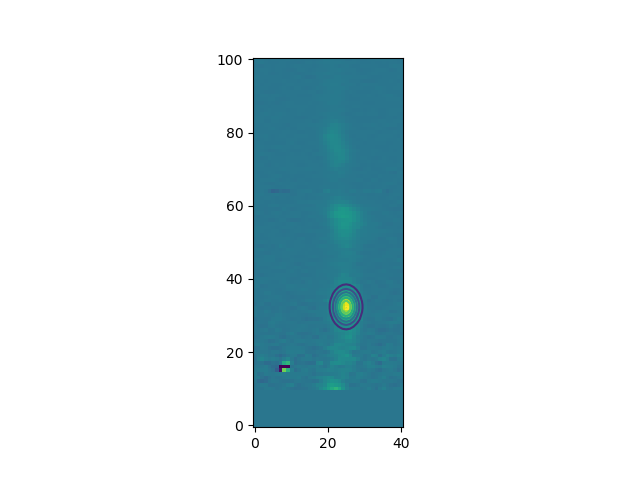

[3.52816464e-16 3.23795895e+01 2.49408304e+01 3.08250830e+00
 2.23585760e+00]


In [79]:
%matplotlib notebook

plt.imshow(data[140:241, 60:101], origin = 'lower')
plt.contour(fit(Y, X))
print(p)

In [ ]:
%load_ext autoreload
%autoreload 2

In [157]:
from telassar import PVSlice
import astropy.units as u

pv = PVSlice(filename = 'data/HD163296_SIIF_6730.fits')

In [175]:
test = pv.vel_range(vmin = -300, vmax = -50, unit = u.Unit('km/s'))

In [176]:
test.info()

330 x 39 PVSlice (data/HD163296_SIIF_6730.fits)
.data(330 x 39) (arcsec,  km / s)
center:(164.5, 74.0) 
size:(66.000", 996.164 km / s) 
step:(0.200", 6.686 km / s) 


In [170]:
dx = pv.world.get_spectral_step(unit = u.Unit('km/s'))
dy = pv.world.get_spatial_step(unit = u.arcsec)
sizex = dx * pv.world.naxis2
sizey = dy * pv.world.naxis1

pv.world.naxis2

149

In [142]:
import logging
logging.basicConfig(level=20)
log = logging.getLogger('something here')
#logging.setLevel(logging.DEBUG)
log.info('Something')

INFO:something here:Something
